In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imageio
import rawpy
import sys
import os
import gc
import time
import random
from glob import glob
from tqdm import tqdm
from collections import defaultdict
from IPython import display
from skimage.metrics import mean_squared_error as MSE
from skimage.metrics import structural_similarity as SSIM

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from torch.optim import Adam

D:\Tool\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [ ]:


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class DeepLabV3(nn.Module):
    def __init__(self, enc_chs, dec_chs, out_ch, out_sz):
        super(DeepLabV3, self).__init__()
        self.enc_chs = enc_chs
        self.dec_chs = dec_chs
        self.out_ch = out_ch
        self.out_sz = out_sz

        # Encoder
        self.encoder = nn.ModuleList([
            DoubleConv(enc_chs[i], enc_chs[i+1]) for i in range(len(enc_chs) - 1)
        ])

        # Decoder
        self.upconvs = nn.ModuleList([
            nn.ConvTranspose2d(dec_chs[i], dec_chs[i+1], kernel_size=2, stride=2) for i in range(len(dec_chs) - 1)
        ])
        self.decoder = nn.ModuleList([
            DoubleConv(dec_chs[i] + enc_chs[-(i+2)], dec_chs[i+1]) for i in range(len(dec_chs) - 1)
        ])

        # Final layer
        self.final_conv = nn.Conv2d(dec_chs[-1], out_ch, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc_outs = []
        for enc in self.encoder:
            x = enc(x)
            enc_outs.append(x)
            x = F.max_pool2d(x, 2)

        # Decoder
        for i, (upconv, dec) in enumerate(zip(self.upconvs, self.decoder)):
            x = upconv(x)
            # Ensure the size matches before concatenation
            enc_out = enc_outs[-(i+1)]
            if x.shape[2:] != enc_out.shape[2:]:
                x = F.interpolate(x, size=enc_out.shape[2:], mode='bilinear', align_corners=False)
            x = torch.cat((x, enc_out), dim=1)
            x = dec(x)

        # Final layer
        x = self.final_conv(x)
        return x


class CFG:
    
    encoder = (3,64,128,256)
    decoder = (256, 128, 64)
    out_ch  = 4
    out_sz  = (512, 512)
    lr      = 8e-5
    lr_decay= 1e-6
    epochs  = 100
    loss    = nn.MSELoss()
    name    = 'DeepLabV3-rev-isp.pt'
    out_dir = './out5'
    save_freq = 1

In [4]:
PATH    = f'data'
PATH2    = f'noise'
def get_filenames(path):
    train_raws = sorted(glob(PATH + '/train/*.npy'))
    train_rgbs = sorted(glob(PATH + '/train/*.png'))
    #==========================================!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!+=============================================
    valid_rgbs = sorted(glob(PATH2 + '/2/*.png'))
    assert len(train_raws) == len(train_rgbs)
    print (f'Training samples: {len(train_raws)} \t Validation samples: {len(valid_rgbs)}')
    return train_raws, train_rgbs, valid_rgbs

def load_img (filename, debug=False, norm=True, resize=None):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if norm:   
        img = img / 255.
        img = img.astype(np.float32)
    if debug:
        print (img.shape, img.dtype, img.min(), img.max())
        
    if resize:
        img = cv2.resize(img, (resize[0], resize[1]), interpolation = cv2.INTER_AREA)
        
    return img

def save_rgb (img, filename):
    if np.max(img) <= 1:
        img = img * 255
    
    img = img.astype(np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
    cv2.imwrite(filename, img)
    

def load_raw(raw, max_val=2**10):
    raw = np.load (raw)/ max_val
    return raw.astype(np.float32)


########## VISUALIZATION

def demosaic (raw):
    """Simple demosaicing to visualize RAW images
    Inputs:
     - raw: (h,w,4) RAW RGGB image normalized [0..1] as float32
    Returns: 
     - Simple Avg. Green Demosaiced RAW image with shape (h*2, w*2, 3)
    """
    
    assert raw.shape[-1] == 4
    shape = raw.shape
    
    red        = raw[:,:,0]
    green_red  = raw[:,:,1]
    green_blue = raw[:,:,2]
    blue       = raw[:,:,3]
    avg_green  = (green_red + green_blue) / 2
    image      = np.stack((red, avg_green, blue), axis=-1)
    image      = cv2.resize(image, (shape[1]*2, shape[0]*2))
    return image


def mosaic(rgb):
    """Extracts RGGB Bayer planes from an RGB image."""
    
    assert rgb.shape[-1] == 3
    shape = rgb.shape
    
    red        = rgb[0::2, 0::2, 0]
    green_red  = rgb[0::2, 1::2, 1]
    green_blue = rgb[1::2, 0::2, 1]
    blue       = rgb[1::2, 1::2, 2]
    
    image = np.stack((red, green_red, green_blue, blue), axis=-1)
    return image


def gamma_compression(image):
    """Converts from linear to gamma space."""
    return np.maximum(image, 1e-8) ** (1.0 / 2.2)

def tonemap(image):
    """Simple S-curved global tonemap"""
    return (3*(image**2)) - (2*(image**3))

def postprocess_raw(raw):
    """Simple post-processing to visualize demosaic RAW imgaes
    Input:  (h,w,3) RAW image normalized
    Output: (h,w,3) post-processed RAW image
    """
    raw = gamma_compression(raw)
    raw = tonemap(raw)
    raw = np.clip(raw, 0, 1)
    return raw

def plot_pair (rgb, raw, t1='RGB', t2='RAW', axis='off'):
    
    fig = plt.figure(figsize=(16, 8), dpi=100)
    plt.subplot(1,2,1)
    plt.title(t1)
    plt.axis(axis)
    plt.imshow(rgb)

    plt.subplot(1,2,2)
    plt.title(t2)
    plt.axis(axis)
    plt.imshow(raw)
    plt.show()

########## METRICS

def PSNR(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    if(mse == 0):  
        return np.inf
    
    max_pixel = np.max(y_true)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr
class LoadData(Dataset):

    def __init__(self, root, rgb_files, raw_files=None, debug=False, test=None):
        
        self.root = root
        self.test = test
        self.rgbs = sorted(rgb_files)
        if self.test:
            self.raws = None
        else:
            self.raws = sorted(raw_files)
            
        self.debug = debug
        if self.debug:
            self.rgbs = self.rgbs[:100]
            self.raws = self.raws[:100]
        
    def __len__(self):
        return len(self.rgbs)

    def __getitem__(self, idx):

        rgb = load_img (self.rgbs[idx], norm=True)
        rgb = torch.from_numpy(rgb.transpose((2, 0, 1)))
        
        if self.test:
            return rgb, self.rgbs[idx]
        else:
            raw = load_raw (self.raws[idx])
            raw = torch.from_numpy(raw.transpose((2, 0, 1)))
            return rgb, raw
train_raws, train_rgbs, valid_rgbs = get_filenames(PATH)
BATCH_TEST  = 1
test_dataset = LoadData(root=PATH, rgb_files=valid_rgbs, test=True)
test_loader  = DataLoader(dataset=test_dataset, batch_size=BATCH_TEST, shuffle=False, num_workers=0,
                         pin_memory=True, drop_last=False)

Training samples: 2121 	 Validation samples: 2


In [ ]:
model = DeepLabV3(enc_chs=CFG.encoder, dec_chs=CFG.decoder, out_ch=CFG.out_ch, out_sz=CFG.out_sz)
# 加载权重文件
device = torch.device("cuda")
pretrained_weights_path = r"F:\研究生\CVPR-workshop\rgb2raw\out7\87.pt"
model = torch.load(pretrained_weights_path, map_location=device, weights_only=False)
model = model.to(device)

In [8]:
#------------------------!!!!!!!!!!!!!!!!!!!---------------------------
SUBMISSION_PATH = './noise/'
runtime = []

see_map1 = {}
see_map2 = {}

cnt = 0
model.eval()
with torch.no_grad():
    for (rgb_batch, rgb_name) in tqdm(test_loader):
        rgb_batch = rgb_batch.to(device)
        rgb_name  = rgb_name[0].split('/')[-1].replace('.png', '')
        
        st = time.time()
        recon_raw = model(rgb_batch)
        tt = time.time() - st
        runtime.append(tt)
        
        recon_raw = recon_raw[0].detach().cpu().permute(1, 2, 0).numpy()
        rgb_batch = rgb_batch[0].detach().cpu().permute(1, 2, 0).numpy()


        see_map1[rgb_name] = (rgb_batch)
        see_map2[rgb_name] = postprocess_raw(demosaic(recon_raw))

        
        if cnt == 120:
            break
        #     plot_pair(rgb_batch, postprocess_raw(demosaic(recon_raw)))
        
        ## save as np.uint16
        assert recon_raw.shape[-1] == 4
        recon_raw = (recon_raw * 1024).astype(np.uint16)
        np.save(SUBMISSION_PATH + rgb_name + '.npy', recon_raw) 
        cnt+=1

print (np.mean(runtime)) ## add into the readme!

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.75it/s]

0.002496480941772461


In [11]:

def showimg(it):
    plot_pair(see_map1[it], see_map2[it])
    image_data = np.load('F:\\研究生\\CVPR-workshop\\rgb2raw\\noise\\'+it.replace('\\', '\\\\')+'.npy')
    raw = postprocess_raw(demosaic(image_data.astype(np.float32) / 1024))
    fig = plt.figure(figsize=(6, 6), dpi=100)
    plt.title('origin')
    plt.axis('off')
    plt.imshow(raw)
    plt.show()


2\input :


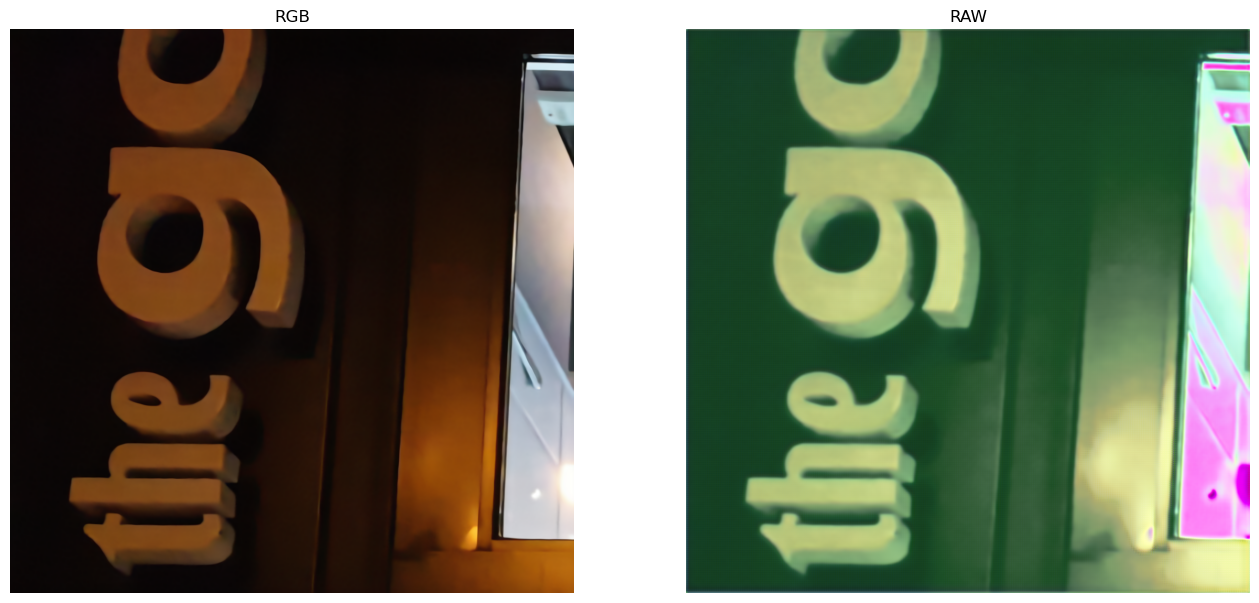

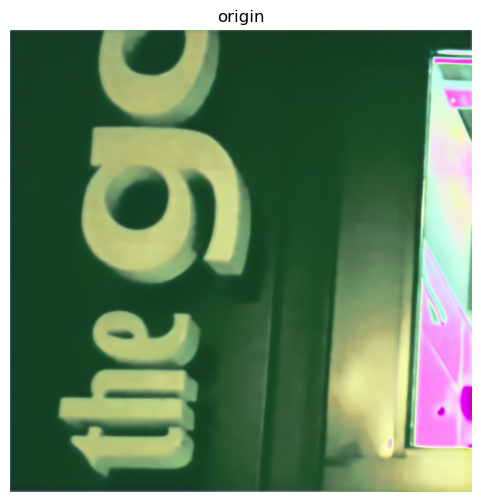

2\input2 :


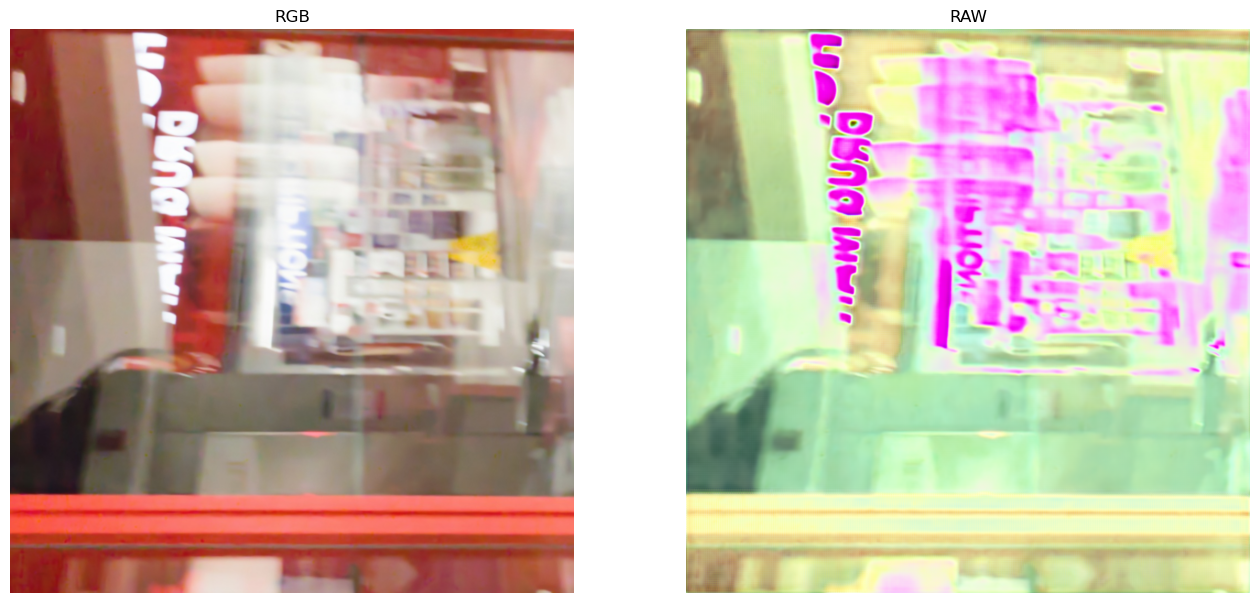

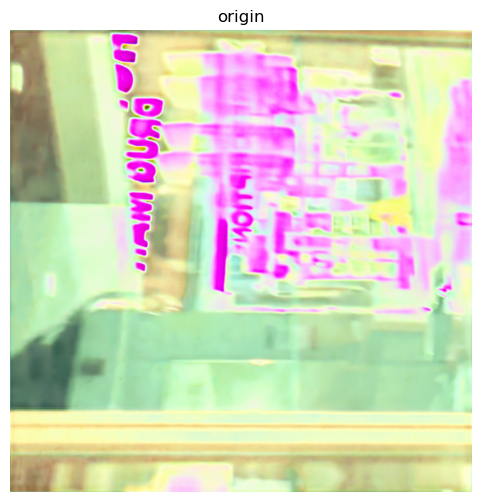

In [12]:
for i in see_map1:
    print(i, ':')
    showimg(i)

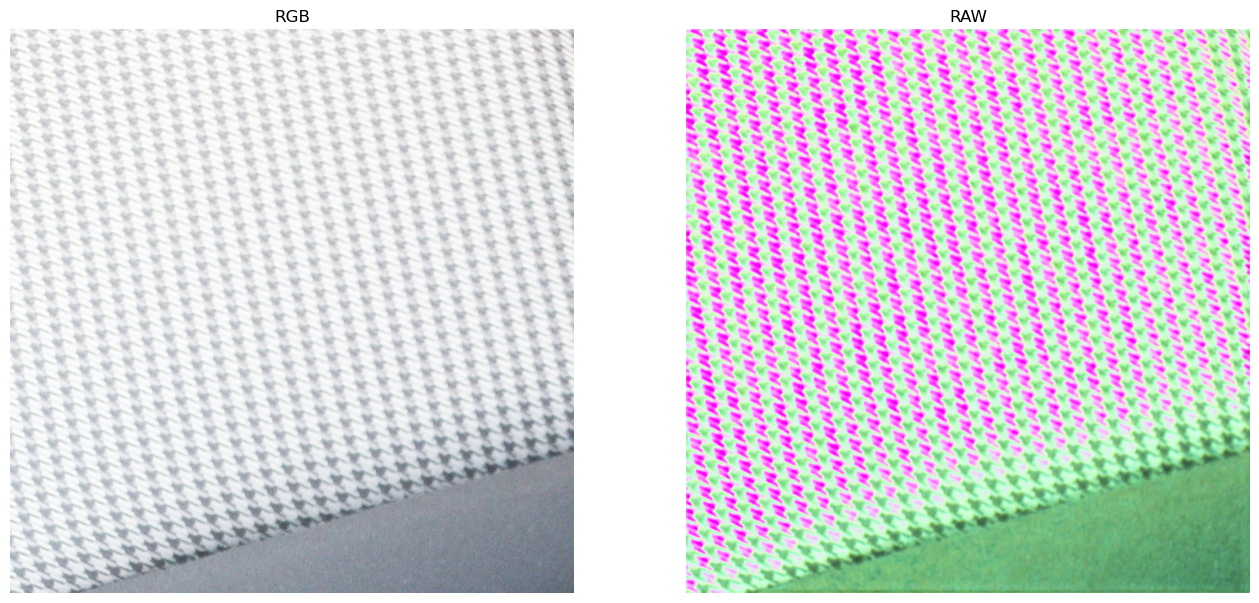

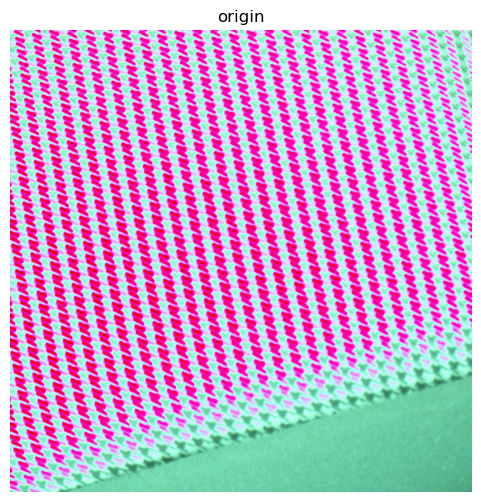

In [16]:
# Ours
showimg('train\\1009')